In [1]:
# kaggle competitions submit -c [COMPETITION] -f [FILE] -m [MESSAGE]: make a competition submission


In [2]:
import pyarrow.parquet as pa
import pandas as pd



In [3]:
tbl = pa.read_table('jane-street-real-time-market-data-forecasting/train.parquet/partition_id=0/part-0.parquet').to_pandas()

In [4]:
# schema = pa.read_schema('jane-street-real-time-market-data-forecasting/lags.parquet/date_id=0/part-0.parquet')
# tbllags = pa.read_table('jane-street-real-time-market-data-forecasting/lags.parquet/date_id=0/part-0.parquet', schema=schema).to_pandas()

In [5]:
#symbol : financial instrument (20 in the parquet)
# Transformer - input - seq of n instruments, window (60) * n features, to predict outcome of each instrument
# embedding of window * n features (60 * 100) to a fixed size vector (1024)

# VAR model

In [6]:

tbl['symbol_id'].value_counts()

symbol_id
1     143481
16    141783
7     140934
19    139236
9     138387
0     138387
38    133293
33    115464
12    112068
13    110370
8     108672
10    102729
2      73863
17     68769
34     61128
3      60279
11     58581
14     54336
15     22074
30     20376
Name: count, dtype: int64

#### Drop columns with NA

In [7]:
# 78 features, 8 targets
# dropped 9 columns
drop_threshold = 0.5
print((tbl.isna().sum() <tbl.shape[0]*drop_threshold).sum(), tbl.shape[1])


84 93


In [151]:
from sklearn.preprocessing import MinMaxScaler,OneHotEncoder
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.pipeline import Pipeline
import numpy as np
from sklearn.compose import ColumnTransformer

def preprocess(df, drop_threshold=0.8):
    """
    Preprocess DataFrame:
    1) Remove columns with excessive NAs.
    2) Add lagged variables for float columns.
    3) Drop responder columns.
    4) Add time-based features.
    5) Scale numeric columns and encode categorical columns.
    6) Output a processed Pandas DataFrame.
    """
    tbl = df.copy()

    # 1. Remove columns with excessive NAs
    tbl = tbl[tbl.columns[tbl.isna().sum() < tbl.shape[0] * drop_threshold]]

    # 2. Create lagged variables for float columns
    float_cols = tbl.select_dtypes(include='float').columns
    lagged_floats = tbl[float_cols].diff().add_suffix('_l1')
    responder = tbl['responder_6']
    
    # 3. Drop responder columns
    tbl.drop(columns=['responder_0', 'responder_1', 'responder_2', 
                      'responder_3', 'responder_4', 'responder_5', 
                      'responder_6', 'responder_7', 'responder_8'], inplace=True, errors='ignore')

    # 4. Concatenate lagged variables and add time-based features
    # tbl = pd.concat([tbl, lagged_floats], axis=1).iloc[1:]  # Drop first row due to NaN from diff
    tbl[lagged_floats.columns] = lagged_floats
    tbl['day'] = tbl['date_id'] % 5
    tbl['t'] = ((tbl['date_id'] +1).astype(int)* 1000 + tbl['time_id'].astype(int)).astype(int)
    
    tbl = tbl[~tbl.duplicated(subset=['symbol_id', 't'], keep=False)]
    
    # 5. Define column categories for scaling and encoding
    float_cols = tbl.select_dtypes(include='float').columns
    int_cols = tbl.iloc[:, 3:-1].select_dtypes(exclude='float').columns #last column is time
    additional_cols = ['t', 'symbol_id']
    # 6. Set up column transformers for preprocessing
    # Float columns: impute + scale
    float_pipe = Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', MinMaxScaler())
    ])
    
    # Integer columns: impute + one-hot encode
    int_pipe = Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])

    # Combine preprocessing steps
    preprocessor = ColumnTransformer([
        ('float_pipe', float_pipe, float_cols),
        ('int_pipe', int_pipe, int_cols)
    ], remainder='passthrough')  # Keep additional_cols as-is

    # 7. Apply transformations
    processed_data = preprocessor.fit_transform(tbl.iloc[:,3:-1])
    feature_names = (
        list(float_cols) +
        list(preprocessor.named_transformers_['int_pipe']['onehot'].get_feature_names_out(int_cols))     )

    # Convert the processed array back to a DataFrame
    processed_df = pd.DataFrame(processed_data, columns=feature_names)
    # processed_df= pd.concat([processed_df, tbl[additional_cols]], axis=1)
    processed_df[additional_cols] = tbl[additional_cols].values

    

    # 8. Process responder column
    responder = float_pipe.fit_transform(responder.values.reshape(-1, 1))
    responder_df = pd.DataFrame({
        'symbol_id': tbl['symbol_id'].values,
        't': tbl['t'].values,
        'responder': responder.flatten()
    })


    print("Successfully created database")
    return processed_df, responder_df
X, Y = preprocess(tbl)


AttributeError: 'numpy.ndarray' object has no attribute 'values'

In [150]:
# need to fix Y
Y

array([[0.5775981 ],
       [0.57036656],
       [0.71093524],
       ...,
       [0.45921987],
       [0.5254584 ],
       [0.53474003]], dtype=float32)

In [125]:
# list of
# Step 1: Extract unique time steps
time_steps = X['t'].unique()

# Step 2: Create a mapping from symbol_id to indices
symbol_ids = X['symbol_id'].unique()
symbol_id_to_idx = {sid: idx for idx, sid in enumerate(symbol_ids)}

# Step 3: Create a list to store (symbol_id, features) for each time step
time_list = []

# Step 4: Group data by time and collect (symbol_id, features) pairs
for time in time_steps:
    # Filter rows for the current time step
    time_data = X[X['t'] == time]
    
    # Create a list of (symbol_id, features) pairs
    time_step_data = [
        (row['symbol_id'], row.iloc[:-2].to_numpy())  # Symbol ID and features
        for _, row in time_data.iterrows()
    ]
    
    # Append the list for this time step
    time_list.append(time_step_data)

# Step 5: Result
print(f"Number of time steps: {len(time_list)}")
print(f"Example for the first time step: {time_list[0]}")

Number of time steps: 144330
Example for the first time step: [(1.0, array([5.14922082e-01, 4.25141722e-01, 2.76412368e-01, 1.64873116e-02,
       6.62612822e-03, 6.86998852e-03, 1.91470403e-02, 7.17003178e-03,
       1.46794515e-02, 4.14019048e-01, 2.79095411e-01, 5.36568165e-01,
       6.30016208e-01, 7.04313755e-01, 2.40398541e-01, 2.77717620e-01,
       8.02395999e-01, 1.25680283e-01, 1.13960654e-01, 4.47752893e-01,
       5.05292773e-01, 4.57852125e-01, 4.40039605e-01, 5.33245742e-01,
       3.82088602e-01, 4.46842343e-01, 4.74118739e-01, 3.91209960e-01,
       4.72215265e-01, 5.45074642e-01, 4.82713908e-01, 5.65052450e-01,
       4.85623896e-01, 5.65330982e-01, 4.48646784e-01, 4.99416977e-01,
       4.02015984e-01, 4.76831019e-01, 4.49066222e-01, 4.35013235e-01,
       5.04012585e-01, 4.97590154e-01, 5.62692583e-01, 2.64526129e-01,
       5.92246652e-01, 3.63012344e-01, 4.74252522e-01, 3.39607358e-01,
       3.57384294e-01, 1.19101387e-02, 8.45158752e-03, 9.89427976e-03,
       4

In [146]:
# time list is likely better for training

#Check what % of (symbol_id, t) pairs are missing
from itertools import product
symbol_ids = X['symbol_id'].unique()
time_steps = X['t'].unique()
complete_pairs = set(product(symbol_ids, time_steps))
actual_pairs = set(zip(X['symbol_id'], X['t']))

missing_pairs = complete_pairs - actual_pairs
fraction_missing = len(missing_pairs) / len(complete_pairs)
fraction_missing

0.3264705882352941

In [105]:
symbol_ids = X['symbol_id'].unique()
time_steps = X['t'].unique()

# Step 2: Create a mapping from symbol_id and t to indices
symbol_id_to_idx = {sid: idx for idx, sid in enumerate(symbol_ids)}
t_to_idx = {t: idx for idx, t in enumerate(time_steps)}

# Step 3: Initialize an empty NumPy array
n_symbols = len(symbol_ids)
n_times = len(time_steps)
n_features = len(X.columns) - 2  # Exclude symbol_id and t columns
array = np.zeros((n_symbols, n_times, n_features))

# Step 4: Populate the NumPy array
for _, row in X.iterrows():
    symbol_idx = symbol_id_to_idx[row['symbol_id']]
    time_idx = t_to_idx[row['t']]
    features = row.iloc[:-2].to_numpy()  # Features are everything except symbol_id and t
    array[symbol_idx, time_idx, :] = features

# Step 5: Result
print("Array Shape:", array.shape)  # (n_symbol_ids, n_time_steps, n_features)


Array Shape: (20, 144330, 180)


In [123]:
X

,weight,feature_05,feature_06,feature_07,feature_08,feature_12,feature_13,feature_14,feature_15,feature_16,...,feature_11_522,feature_11_534,partition_id_0,day_0,day_1,day_2,day_3,day_4,t,symbol_id
0,0.618956,0.465815,0.514922,0.425142,0.276412,0.016487,0.006626,0.006870,0.019147,0.007170,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1000,1
1,0.166931,0.459389,0.513077,0.423677,0.295588,0.016771,0.004933,0.008818,0.019147,0.009365,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1000,7
2,0.331177,0.473393,0.513791,0.424863,0.282561,0.019806,0.005127,0.008762,0.019147,0.004262,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1000,9
3,0.044878,0.476461,0.515538,0.426033,0.257207,0.019513,0.028840,0.017169,0.019147,0.006799,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1000,10
4,0.000000,0.469661,0.515316,0.426816,0.290815,0.015458,0.006381,0.009774,0.019147,0.010846,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1000,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1944205,0.538113,0.433359,0.515824,0.422140,0.289225,0.085359,0.013984,0.036237,0.011784,0.005856,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,170848,19
1944206,0.058864,0.433562,0.518966,0.422609,0.293031,0.036789,0.012028,0.017662,0.017688,0.012130,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,170848,30
1944207,0.164074,0.433480,0.518527,0.422516,0.280665,0.027416,0.003573,0.013570,0.018053,0.008656,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,170848,33
1944208,0.104323,0.433800,0.516151,0.422799,0.284897,0.032054,0.004245,0.018547,0.011321,0.007325,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,170848,34


In [121]:
tbl.loc[tbl['symbol_id'] == 8]

,date_id,time_id,symbol_id,weight,feature_00,feature_01,feature_02,feature_03,feature_04,feature_05,...,responder_0,responder_1,responder_2,responder_3,responder_4,responder_5,responder_6,responder_7,responder_8,partition_id
36511,4,0,8,1.068149,NaN,NaN,NaN,NaN,NaN,0.012285,...,-0.094755,2.992783,0.108670,-0.720934,0.840274,0.291718,-0.866926,-0.263764,0.328823,0
36523,4,1,8,1.068149,NaN,NaN,NaN,NaN,NaN,0.142883,...,-0.067873,3.160088,0.340581,-0.631832,0.746766,0.271342,-0.569250,-0.211643,0.321152,0
36535,4,2,8,1.068149,NaN,NaN,NaN,NaN,NaN,0.166715,...,-0.001085,3.336260,0.427150,-0.375338,0.826179,0.234929,-0.511967,-0.296177,0.232354,0
36547,4,3,8,1.068149,NaN,NaN,NaN,NaN,NaN,0.193263,...,0.023738,2.467765,-0.009941,-0.477206,0.707003,0.507257,-0.732790,-0.311242,0.930264,0
36559,4,4,8,1.068149,NaN,NaN,NaN,NaN,NaN,0.113729,...,0.034067,1.759683,0.697850,-0.289970,0.558375,2.033728,-0.598898,-0.374795,3.103030,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1944120,169,844,8,1.665622,NaN,NaN,NaN,NaN,NaN,-0.025525,...,2.298172,0.387053,-0.020073,0.356287,0.434917,0.049107,-1.070147,-0.380773,0.098429,0
1944139,169,845,8,1.665622,NaN,NaN,NaN,NaN,NaN,-0.086819,...,1.019323,0.674200,-0.155365,0.776088,0.365522,-0.831677,-0.927908,-0.406387,-1.763450,0
1944158,169,846,8,1.665622,NaN,NaN,NaN,NaN,NaN,-0.215062,...,0.332912,0.600067,1.761229,0.716117,0.289048,0.590841,-0.935017,-0.231192,-1.647792,0
1944177,169,847,8,1.665622,NaN,NaN,NaN,NaN,NaN,-0.014160,...,0.547053,0.482849,2.371684,0.700645,0.418779,1.052429,-0.911857,-0.369240,-1.262079,0


In [22]:
array.shape

(20, 2134260)

In [12]:
tbl

,date_id,time_id,symbol_id,weight,feature_00,feature_01,feature_02,feature_03,feature_04,feature_05,...,responder_0,responder_1,responder_2,responder_3,responder_4,responder_5,responder_6,responder_7,responder_8,partition_id
0,0,0,1,3.889038,NaN,NaN,NaN,NaN,NaN,0.851033,...,0.738489,-0.069556,1.380875,2.005353,0.186018,1.218368,0.775981,0.346999,0.095504,0
1,0,0,7,1.370613,NaN,NaN,NaN,NaN,NaN,0.676961,...,2.965889,1.190077,-0.523998,3.849921,2.626981,5.000000,0.703665,0.216683,0.778639,0
2,0,0,9,2.285698,NaN,NaN,NaN,NaN,NaN,1.056285,...,-0.864488,-0.280303,-0.326697,0.375781,1.271291,0.099793,2.109352,0.670881,0.772828,0
3,0,0,10,0.690606,NaN,NaN,NaN,NaN,NaN,1.139366,...,0.408499,0.223992,2.294888,1.097444,1.225872,1.225376,1.114137,0.775199,-1.379516,0
4,0,0,14,0.440570,NaN,NaN,NaN,NaN,NaN,0.955200,...,-0.373387,-0.502764,-0.348021,-3.928148,-1.591366,-5.000000,-3.572820,-1.089123,-5.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1944205,169,848,19,3.438631,NaN,NaN,NaN,NaN,NaN,-0.028087,...,0.983339,-0.669860,0.272615,-3.676842,-1.221126,1.070584,0.465345,0.207483,0.874975,0
1944206,169,848,30,0.768528,NaN,NaN,NaN,NaN,NaN,-0.022584,...,0.992615,0.961595,1.089402,0.796034,0.488380,1.846634,-0.088542,-0.008324,-0.153451,0
1944207,169,848,33,1.354696,NaN,NaN,NaN,NaN,NaN,-0.024804,...,1.701618,0.757672,-5.000000,-3.174266,-1.110790,-3.349107,-0.407801,-0.185842,-0.931004,0
1944208,169,848,34,1.021797,NaN,NaN,NaN,NaN,NaN,-0.016138,...,-2.036891,-0.064228,1.919665,1.827681,0.872019,3.248694,0.254584,0.090288,0.434726,0


In [13]:
X.isna().sum().sum()

NameError: name 'X' is not defined

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader, Subset, TensorDataset
cutoff = -100000
train_dataset = TensorDataset(torch.tensor(X[:cutoff].values), torch.tensor(Y[:cutoff].values))
val_dataset = TensorDataset(torch.tensor(X[cutoff:].values), torch.tensor(Y[cutoff:].values))
bs =2048
trainloader = DataLoader(train_dataset, batch_size=bs, shuffle=False)
valloader = DataLoader(val_dataset, batch_size=bs, shuffle=False)

#### Stationarity
Symbol 0:
almost all are nonstationary at some point in time -> we should difference all and append

In [10]:
# should add lags of time (to show gap in time)
# consider the lags issue by adding lags of responders
selected = tbl.loc[tbl['symbol_id'] == 1] #.loc[ tbl['date_id']==1]
selected_f =selected['feature_70']
selected_t = selected['t']
window = (0, 1000)

KeyError: 't'

#### ADF (Manual)

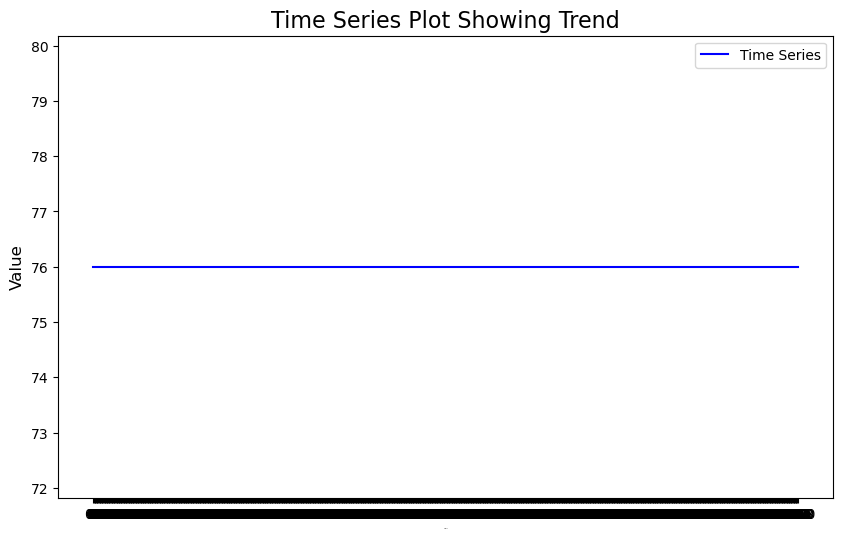

In [52]:
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
plt.figure(figsize=(10, 6))
plt.plot(selected_t[window[0]:window[1]], selected_f[window[0]:window[1]], label="Time Series", color="blue")
plt.title("Time Series Plot Showing Trend", fontsize=16)
plt.xlabel("Time", fontsize=0)
plt.ylabel("Value", fontsize=12)
plt.legend()
plt.grid(False)
plt.show()

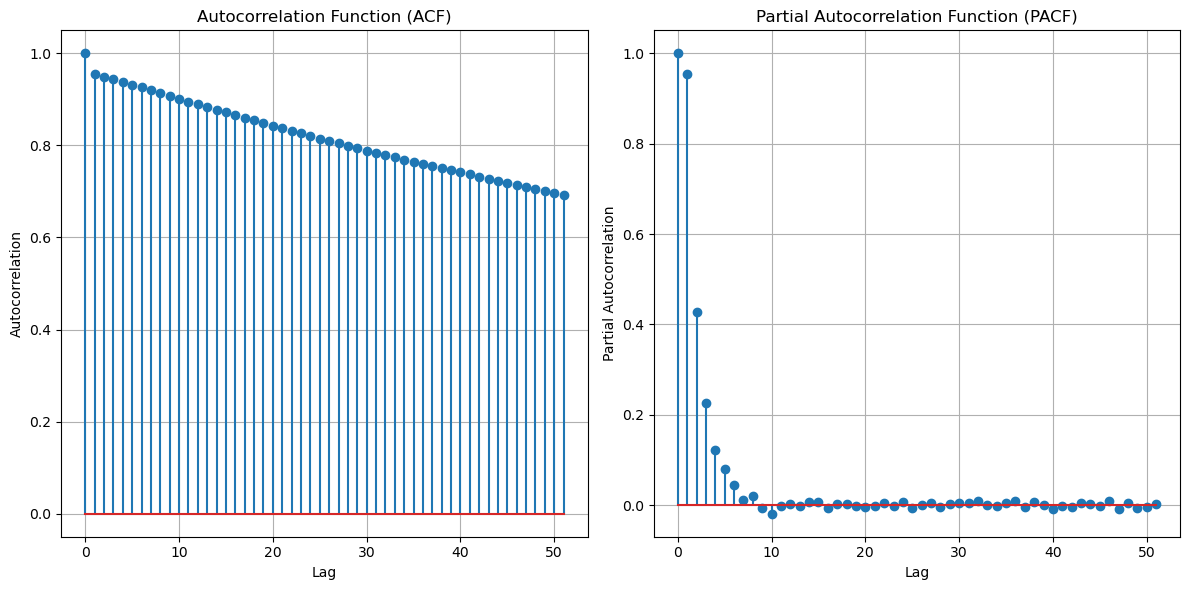

In [43]:
from statsmodels.tsa.stattools import acf, pacf
acf_values = acf(selected_f)
pacf_values = pacf(selected_f)
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Plot ACF
ax[0].stem(range(len(acf_values)), acf_values)
ax[0].set_title("Autocorrelation Function (ACF)")
ax[0].set_xlabel("Lag")
ax[0].set_ylabel("Autocorrelation")
ax[0].grid()

# Plot PACF
ax[1].stem(range(len(pacf_values)), pacf_values)
ax[1].set_title("Partial Autocorrelation Function (PACF)")
ax[1].set_xlabel("Lag")
ax[1].set_ylabel("Partial Autocorrelation")
ax[1].grid()

plt.tight_layout()
plt.show()

In [ ]:
def stationarity(df, threshold=0.1):
    results = {}
    # Filter only numeric columns
    numeric_df = df.select_dtypes(include='number')
    
    for col in numeric_df.columns:
        original_var = numeric_df[col].var()
        differenced_var = numeric_df[col].diff().var()
        results[col] = (differenced_var / original_var) < threshold
    
    return results
# stationarity(selected)

1              00
2              00
3              00
4              00
5              00
            ...  
1944205    169848
1944206    169848
1944207    169848
1944208    169848
1944209    169848
Name: t, Length: 1944209, dtype: object

In [22]:
X.drop(columns = ['t'], inplace = True)

1              00
2              00
3              00
4              00
5              00
            ...  
1944205    169848
1944206    169848
1944207    169848
1944208    169848
1944209    169848
Name: t, Length: 1944209, dtype: object

In [17]:

from sklearn.model_selection import TimeSeriesSplit
import torch
import numpy as np

TypeError: can't convert np.ndarray of type numpy.object_. The only supported types are: float64, float32, float16, complex64, complex128, int64, int32, int16, int8, uint8, and bool.

In [ ]:
# tscv = TimeSeriesSplit(n_splits=5, test_size = X.shape[0]//200)
# combine the indices for the 5 splits into one for train and val, and initialize ONE dataloader

In [ ]:
X.shape

(1944210, 84)

In [ ]:
X.shape

(1944210, 84)

In [ ]:
train_idx.shape

(1895605,)

In [ ]:
train_subset = Subset(dataset, tscv.split(X)[0][0])